In [1]:
%matplotlib inline
import cv2
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

In [2]:
cap = cv2.VideoCapture(1)

In [3]:
def get_frame_rgb(cap):
    _, frame = cap.read()
    frame = np.copy(frame)
    #plt.imshow(frame)
    target_width = 450
    target_height = frame.shape[1] * target_width / frame.shape[0]
    frame1 = cv2.resize(frame, (target_height, target_width))
    framergb = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
    return framergb

In [4]:
def get_mask(framergb):
    frame2 = cv2.cvtColor(framergb, cv2.COLOR_RGB2HSV)
    
    lower_red = np.array([160,50,50])
    upper_red = np.array([179,255,255])

    # Threshold the HSV image to get only blue colors
    mask = cv2.inRange(frame2, lower_red, upper_red)

    # Bitwise-AND mask and original image
    #res = cv2.bitwise_and(frame2, frame2, mask = mask)
    #plt.imshow(mask)
    return mask

In [5]:
def get_keypoints(mask):
    #canvas = np.copy(framergb)

    # Setup SimpleBlobDetector parameters.
    params = cv2.SimpleBlobDetector_Params()

    # Change thresholds
    params.minThreshold = 100;
    params.maxThreshold = 100;

    # Filter by Area.
    params.filterByArea = False
    params.minArea = 1500

    # Filter by Circularity
    params.filterByCircularity = False
    params.minCircularity = 0.1

    # Filter by Convexity
    params.filterByConvexity = False
    params.minConvexity = 0.87

    # Filter by Inertia
    params.filterByInertia = False
    params.minInertiaRatio = 0.01

    detector = cv2.SimpleBlobDetector_create()

    # Detect blobs.
    keypoints = detector.detect(255-mask)

    # Draw detected blobs as red circles.
    # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
    #im_with_keypoints = cv2.drawKeypoints(canvas, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    points = [(kp.pt[1], kp.pt[0]) for kp in keypoints]

    #plt.imshow(im_with_keypoints)
    return np.array(points)

In [6]:
def prepare_input(frame, target_width = 450):
    target_height = frame.shape[1] * target_width / frame.shape[0]
    frame1 = cv2.resize(frame, (target_height, target_width))
    framergb = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
    return framergb

In [7]:
def crop(frame, tl, br):
    return frame[tl[0]:br[0], tl[1]:br[1]]

In [8]:
def match_corners(frame, template):
    w, h = template.shape[::-1]
    res = cv2.matchTemplate(frame, template, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    top_left = (max_loc[1], max_loc[0])
    bottom_right = (top_left[0] + h, top_left[1] + w)
    return top_left, bottom_right

In [9]:
def nearest_in_array(pt, arr):
    return np.argmin(np.linalg.norm(pt - arr, axis = 1))

In [10]:
def plot_matches(canvas, kp_new, kp_old, assignments, tl, tl_old):
    for i, j in enumerate(assignments):
        pt_new = kp_new[i] + np.array(tl)
        pt_old = kp_old[j] + np.array(tl_old)
        pt_new = tuple([int(t) for t in pt_new])
        pt_old = tuple([int(t) for t in pt_old])
        pt_new = tuple([t for t in reversed(pt_new)])
        pt_old = tuple([t for t in reversed(pt_old)])
        cv2.circle(canvas, pt_new, 10, (255, 0, 0), -1)
        cv2.circle(canvas, pt_old, 10, (0, 0, 255), -1)
        cv2.line(canvas, pt_new, pt_old, (0, 255, 0), 3)
    return canvas

In [24]:
frame_old = cv2.imread('tracking1.jpg')
frame_old = prepare_input(frame_old)
tl_old = (150, 100)
br_old = (310, 300)

with tqdm() as pbar:
    while(True):
        frame = get_frame_rgb(cap)

        frame_mask = get_mask(frame)
        frame_old_mask = get_mask(frame_old)

        template = crop(frame_old_mask, tl_old, br_old)
        tl, br = match_corners(frame_mask, template)

        frame_mask_found = crop(frame_mask, tl, br)

        kp_new = get_keypoints(frame_mask_found)
        kp_old = get_keypoints(template)

        assignments = [nearest_in_array(pt, kp_old) for pt in kp_new]
        distances = [np.linalg.norm(kp_new[i] - kp_old[j]) for i, j in enumerate(assignments)]

        new_to_remove = np.where(distances > np.mean(distances))[0]
        kp_new = [pt for i, pt in enumerate(kp_new) if i not in new_to_remove]
        assignments = [pt for i, pt in enumerate(assignments) if i not in new_to_remove]
        distances = [pt for i, pt in enumerate(distances) if i not in new_to_remove]

        is_ok = np.median(distances) <= 10 and len(kp_new) >= 10
        
        canvas = np.copy(frame)
        if is_ok:
            plot_matches(canvas, kp_new, kp_old, assignments, tl, tl_old)

        pbar.set_postfix(points = len(kp_new), mean_dist = np.mean(distances))

        canvas = cv2.addWeighted(canvas, 0.8, frame_old, 0.2, 0.0)

        cv2.imshow('Matching', canvas)
        cv2.waitKey(1)
        
        if not is_ok:
            continue

        #plt.figure()
        #plt.imshow(canvas)
        #plt.show()

        template = frame_mask_found
        frame_old = frame
        tl_old = tl
        br_old = br

        pbar.update()

11it [00:06,  3.64it/s, mean_dist=2.48, points=13]


KeyboardInterrupt: 

In [16]:
pbar.close()

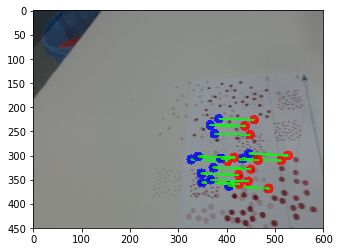

In [25]:
plt.imshow(canvas)